In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import sklearn.metrics as me
from __future__ import division
%matplotlib inline

[ 1.29289322  4.70710678] [ 6.70710678  3.70710678] [[1 7]
 [5 7]
 [6 7]
 [9 8]]


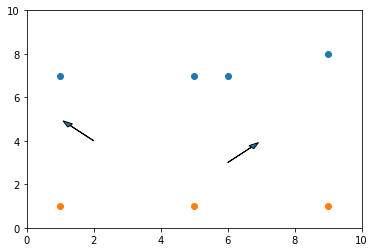

In [2]:
layer_1 = np.array([[1,7],[5,7],[6,7], [9,8]])
layer_2 = np.array([[1,1],[5,1],[9,1]])
layer_3 = np.array([[1,1],[3,2],[7,4]])

dip_pos_1 = np.array([2,4])
dip_angle_1 = 135
dip_pos_1_v = np.array([np.cos(np.deg2rad(dip_angle_1))*1,
                        np.sin(np.deg2rad(dip_angle_1))]) + dip_pos_1



dip_pos_2 = np.array([6,3])
dip_angle_2 = 45
dip_pos_2_v = np.array([np.cos(np.deg2rad(dip_angle_2))*1, 
                        np.sin(np.deg2rad(dip_angle_2))]) + dip_pos_2


plt.arrow(dip_pos_1[0],dip_pos_1[1], dip_pos_1_v[0]-dip_pos_1[0],
          dip_pos_1_v[1]-dip_pos_1[1], head_width = 0.2)
plt.arrow(dip_pos_2[0],dip_pos_2[1],dip_pos_2_v[0]-dip_pos_2[0], 
          dip_pos_2_v[1]-dip_pos_2[1], head_width = 0.2)
plt.plot(layer_1[:,0],layer_1[:,1], "o")
plt.plot(layer_2[:,0],layer_2[:,1], "o")
plt.xlim(0,10)
plt.ylim(0,10)
print (dip_pos_1_v, dip_pos_2_v, layer_1)
layers = np.asarray([layer_1,layer_2])
dips = np.asarray([dip_pos_1,dip_pos_2])

In [3]:
#layers = [np.random.uniform(0,10,(100,2)) for i in range(2)]
#dips = np.random.uniform(0,10, (30,2))
#dips_angles = np.random.normal(90,10, 8)

In [4]:
import pdb;

In [5]:
# =================================0
# THE INCREMENTS OF POTENTIAL

def cov_cubic_f(r,a = 6, c_o = 1):
    ans_d0 = c_o*(1-7*(r/a)**2+35/4*(r/a)**3-7/2*(r/a)**5+3/4*(r/a)**7)
    ans_d0[r>a] = 0
    return ans_d0

def cov_cubic_d1_f(r,a = 6., c_o = 1):
    ans_d1 = (-7* (a - r)**3 *r* (8* a**2 + 9 *a* r + 3* r**2)* (c_o))/(4* a**7)
    ans_d1[r>a] = 0.
    return ans_d1
                    
def cov_cubic_d2_f(r, a = 6, c_o = 1):
    ans_d2 = (-7 * (4.* a**5. - 15. *a**4. * r + 20. *( a**2)*(r**3) - 9* r**5) * 
            (c_o))/(2*a**7)
    
    ans_d2[r>a] = 0
    return ans_d2

def cov_cubic_layer(X,Y, a = 6., c_o = 1., verbose = 0):
    """x = Array: Position of the measured points"
    a =  Range of the spherical semivariogram
    C_o = Nugget, variance
    """
    # Creation of r vector
    r_m = np.asarray(euclidean_distances(X,Y))
   
    # Initializing
    # Applying the functio
    C_h = c_o*(1.-7.*(r_m/a)**2.+35./4.*(r_m/a)**3.
                -7./2.*(r_m/a)**5.+3./4.*(r_m/a)**7.)
    C_h[r_m>a] = 0
    if verbose !=0:
        print(r_m>a)
        print ("Our lag matrix is", r_m)
        print("Our covariance matrix is",C_h)
    return C_h

def C_I(layers, a = 6.):
    #print "layers", layers
    layers = np.asarray(layers)
    #print "layers", len(layers)
    for r in range(len(layers)):
        for s in range(len(layers)):
         #   print "layers2", layers[r][1:],layers[s][1:]
        
           # print "nagnoagjja", layers[s][0].reshape(1,-1),layers[r][1:],
            a_p = cov_cubic_layer(layers[r][1:],layers[s][1:], a = a)
            b_p = cov_cubic_layer(layers[s][0].reshape(1,-1),
                                  layers[r][1:], a = a).transpose()
            
            test = cov_cubic_layer(layers[r][1:],layers[s][0].reshape(1,-1), a =a)
            c_p = cov_cubic_layer(layers[s][1:],
                                  layers[r][0].reshape(1,-1),a=a).transpose()
            d_p = cov_cubic_layer(layers[r][0].reshape(1,-1),
                                layers[s][0].reshape(1,-1), a=a)  
            
            #pdb.set_trace()
            #print "s", s,"r", r 
            if s == 0:
                
                C_I_row = a_p-b_p-c_p+d_p
            else:
                C_I_row = np.hstack((C_I_row, a_p-b_p-c_p+d_p)) 
                
        if r == 0:
            C_I = C_I_row
        else:
            C_I = np.vstack((C_I,C_I_row))
   # C_I  += 0.00000001
    return C_I

In [6]:
C_I(layers)

array([[ 1.87105624,  1.77585948,  0.98731906,  0.        ,  0.        ],
       [ 1.77585948,  1.98942794,  1.19742208,  0.        ,  0.        ],
       [ 0.98731906,  1.19742208,  2.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.87105624,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  2.        ]])

In [9]:
#=====================
# THE GRADIENTS

def h_f(dips, direct):
    #pdb.set_trace()
    if direct == "x":
        #print (np.subtract.outer(dips[:,0],dips[:,0]))
        #print (dips[:,0] , dips[:,0].reshape((dips[:,0].shape[0],1)))
      #  print ("hx",dips[:,0] - dips[:,0].reshape((dips[:,0].shape[0],1)))
        return (np.subtract.outer(dips[:,0],dips[:,0]))
    if direct == "y":
      #  print ("hy",dips[:,1] - dips[:,1].reshape((dips[:,1].shape[0],1)))
        return (np.subtract.outer(dips[:,1],dips[:,1]))

def C_G(dips, sig_z = 1, a = 6., C_000 = -14*1/6**2-0.2):
    dips = np.asarray(dips)
    
    
    if len(dips) == 1:
        lalolu = np.ones((2,2))*C_0
        lalolu[0,1 ] = 0
        lalolu[1,0] = 0
        return lalolu
    r = me.euclidean_distances(dips)
   # print ("R",r)
    C_0 = 1
    
    for i in "xy":
        for j in "xy":
            if i == j and j == "x":
                h0 = h_f(dips, direct = i)
                C_G_row =  (C_0*(h0**2/r**3-1/r)*cov_cubic_d1_f(r, a = a) -
                            (h0/r)**2*cov_cubic_d2_f(r, a = a))
               # print ("teta", C_0*(h0**2/r**3-1/r)*cov_cubic_d1_f(r, a = a) -
               #             (h0/r)**2*cov_cubic_d2_f(r, a = a)) 
                
                h1 = h_f(dips, direct = i)
                h2 = h_f(dips, direct = j)
         
                
         #       print ("teta 3" , ((C_0*(h0*h0/r**2)*
         #                     ((1/r)*cov_cubic_d1_f(r, a = a)
         #                      -cov_cubic_d2_f(r, a = a)))))
               # pdb.set_trace()
              #  print "0"
            elif i == j:
         #       print ("a",h0**2)
                h0 = h_f(dips, direct = i)
                C_G_row = np.hstack((C_G_row, (
                            C_0*(h0**2/r**3-1/r)
                          *cov_cubic_d1_f(r, a = a) - 
                            (h0/r)**2*cov_cubic_d2_f(r, a = a))))
               # pdb.set_trace()
            else:
                if j == "x":
                    """
                    print ("cov_d1",cov_cubic_d1_f(r, a = a))
                    print ("cov_d2",cov_cubic_d2_f(r, a = a))
                    print ("a",h1*h2)
                    print ("b", C_0*(h1*h2/r**2) )
                    print ("c", r**2)
                    """

                    h1 = h_f(dips, direct = i)
                    h2 = h_f(dips, direct = j)
                    C_G_row = ((C_0*(h1*h2/r**2)*
                              ((1/r)*cov_cubic_d1_f(r, a = a)
                               -cov_cubic_d2_f(r, a = a))))
               #     pdb.set_trace()
                #    print "2"
                else:
                    h1 = h_f(dips, direct = i)
                    h2 = h_f(dips, direct = j)
      #              print ("a",h1*h2)
                    C_G_row = np.hstack((C_G_row, (C_0*(h1*h2/r**2)*
                              ((1/r)*cov_cubic_d1_f(r, a = a)
                               -cov_cubic_d2_f(r, a = a)))))
                #    pdb.set_trace()
                 #   print "3"
        if i == "x":
            C_G = C_G_row
        else:
            C_G = np.vstack((C_G, C_G_row))
    

  #  C_G[C_G == 0] = 0.0000000000000000000001            
    sol_CG = np.nan_to_num(C_G)
    #sol_CG = C_G
   # sol_CG[sol_CG== 0] = C_0 
    g,h = np.indices(np.shape(sol_CG))
    sol_CG[g==h] = C_000
  #  sol_CG[g+2==h] = 0.01
  #  sol_CG[g-2==h] = 0.01
 #   sol_CG[sol_CG == 0] =  C_0
  #  sol_CG[2,0] = -C_0
  #  sol_CG[3,1] = -C_0
   # print (sol_CG)
    return  sol_CG

In [10]:
C_G(dips)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in true

array([[-0.58888889, -0.10814838,  0.        ,  0.03284077],
       [-0.10814838, -0.58888889,  0.03284077,  0.        ],
       [ 0.        ,  0.03284077, -0.58888889,  0.01500449],
       [ 0.03284077,  0.        ,  0.01500449, -0.58888889]])

In [7]:
#========================================
#THE INTERACTION GRADIENTS/INTERFACES

def h_f_GI(dips, layers, direct):
    if direct == "x":
        return (np.subtract.outer(dips[:,0],layers[:,0]))
    if direct == "y":
        return (np.subtract.outer(dips[:,1],layers[:,1]))
    
def C_GI(dips,layers,  sig_z = 1., a = 6., C_01 = 1, verbose = 0):
    dips = np.asarray(dips)
    layers = np.asarray(layers)
    C_00 = C_01
    
    for k in range(len(layers)):
        for i in "xy":
            r = me.euclidean_distances(dips,layers[k])
            h1 =  h_f_GI(dips,layers[k], i)
           
            Cov_d1 = cov_cubic_d1_f(r, a = a)
         #   pdb.set_trace()
            if verbose != 0:
                print ("dips", dips)
                print ("layers", layers)
                print ("h1", h1, h1[:,0])
                print ("")
                print ("r", r, r[:,0])
                print ("")
                print ("Cov_d1", Cov_d1)
            if i == "x":
                cov_1 = C_00* h1[:,0] / r[:,0] * Cov_d1[:,0]
                cov_j = C_00* h1[:,1:] / r[:,1:] * Cov_d1[:,1:]
               # C_GI_row = alpha * sig_z / a**2 * h1 / r * Cov_d1
              #  print "cov_j, cov_1", cov_j, cov_1.reshape(-1,1), "h1",h1
               
                C_GI_row = cov_j.transpose()-cov_1#.transpose()
               # pdb.set_trace()
            else:
                cov_1 =  C_00* h1[:,0] / r[:,0] * Cov_d1[:,0]
                cov_j =  C_00*  h1[:,1:] / r[:,1:] * Cov_d1[:,1:]
                #C_GI_row = np.hstack((C_GI_row,
               # alpha * sig_z / a**2 * h1 / r * Cov_d1))
                #pdb.set_trace()
                C_GI_row = np.hstack((C_GI_row, cov_j.transpose()-cov_1))
              #  pdb.set_trace()
                #.reshape(-1,1)))
        if k==0:
            C_GI = C_GI_row
        else:
            #pdb.set_trace()
            C_GI = np.vstack((C_GI,C_GI_row))
            
    return C_GI

In [8]:
np.set_printoptions(precision=2)
a = C_GI(dips,layers, verbose =0)
a

array([[  1.28e-01,  -2.32e-02,  -1.51e-01,   9.29e-02],
       [  8.56e-02,  -0.00e+00,  -1.98e-01,   1.10e-01],
       [  6.98e-02,   6.39e-05,  -2.09e-01,   1.06e-04],
       [  1.28e-01,  -1.36e-01,   1.51e-01,  -2.81e-01],
       [  6.98e-02,   1.39e-01,   2.09e-01,  -8.76e-02]])

In [9]:
#======================
# The condition of universality
# GRADIENTS
def U_G(dips):
    dips = np.asarray(dips)
    n = len(dips)
    # x
    U_G = np.array([np.ones(n), #x
                    np.zeros(n),]) #y
     #              dips[:,0]*2, #xx
     #               np.zeros(n), #yy
     #               dips[:,1],])   #xy
                    
    # y
    U_G = np.hstack((U_G,np.array([np.zeros(n),
                                          np.ones(n),])))
     #                                 np.zeros(n),
     #                                     2*dips[:,1]
     #                                 ,dips[:,0]])))
    return U_G

In [10]:
U_G(dips)

array([[ 1.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  1.]])

In [11]:
#======================
# The condition of universality
# Interfaces

def U_I(layers):
    layers = np.asarray(layers)
    for e,l in enumerate(layers):
        if e == 0:
            U_I = np.array([(l[1:,0]-l[0,0]),   # x
                          (l[1:,1]-l[0,1]),])     # y
                      #  np.square(l[1:,0])- np.square(l[0,0]), # xx
                      #  np.square(l[1:,1])- np.square(l[0,1]),  # yy
                      #(l[1:,0]* l[1:,1])-(l[0,0]*l[0,1])])  #xy
        else:
            U_I = np.hstack((U_I, np.array([(l[1:,0]-l[0,0]),   # x
                          (l[1:,1]-l[0,1]),])))     # y
                      #  np.square(l[1:,0])- np.square(l[0,0]), # xx
                      #  np.square(l[1:,1])- np.square(l[0,1]),  # yy
                      # (l[1:,0]* l[1:,1])-(l[0,0]*l[0,1])])))  #xy


    return U_I

In [13]:
U_I(layers)

array([[4, 5, 8, 4, 8],
       [0, 0, 1, 0, 0]])

In [14]:
theano_CG = np.array([[-0.58888888, -0.13136305,  0.        ,  0.03284076],
       [-0.13136305, -0.58888888,  0.03284076,  0.        ],
       [ 0.        , -0.06287594, -0.58888888, -0.10392689],
       [ 0.03284076,  0.        , -0.10392689, -0.58888888]]
)
theano_CG

array([[-0.59, -0.13,  0.  ,  0.03],
       [-0.13, -0.59,  0.03,  0.  ],
       [ 0.  , -0.06, -0.59, -0.1 ],
       [ 0.03,  0.  , -0.1 , -0.59]])

## A matrix

In [15]:
def A_matrix(layers,dips, sig_z = 1., a = 6., C_0 = -14*1/6**2-0.2,
             C_01 = 1, verbose = 0):
    
    #CG = theano_CG
    CG = C_G(dips)
    CGI = C_GI(dips,layers,a = a, C_01=C_01)
    CI = C_I(layers, a = a)
    UG = U_G(dips)
    UI = U_I(layers)
   # print np.shape(UI)[0]
    zeros = np.zeros((np.shape(UI)[0],np.shape(UI)[0]))
    #print CG,CGI.transpose(),UG.transpose()
    A1 = np.hstack((-CG,CGI.transpose(),UG.transpose()))
    A2 = np.hstack((CGI,CI,UI.transpose()))
    A3 = np.hstack((UG,UI,zeros))
    A = np.vstack((A1,A2,A3))
    return A

In [16]:
np.set_printoptions(precision = 2, linewidth= 130, suppress =  True)
aa = A_matrix(layers, dips)
np.shape(aa)
#aa

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in true

(11, 11)

### Dual Kriging

In [17]:
def G_f(dips, dips_v):
    a_g = np.asarray(dips)
    b_g = np.asarray(dips_v)
   # print  a, a[:,0]
   # print  b,b[:,0]
    Gx =  b_g[:,0] - a_g[:,0]       # x
    Gy =  b_g[:,1] -a_g[:,1]        # y
    G = np.hstack((Gx,Gy))
   # G = np.array([-0.71,0.34,0.71,0.93])
    return G

def b(dips,dips_v,n):
    n -= len(dips)*2 # because x and y direction 
    G = G_f(dips,dips_v)
    b = np.hstack((G, np.zeros(n)))
    return b

## Estimator normal

In [18]:
aa = A_matrix(layers, dips)
               
bb = b([dip_pos_1, dip_pos_2], 
       [dip_pos_1_v,dip_pos_2_v], len(aa))
#    bb[1] = 0
print (bb)
sol = np.linalg.solve(aa,bb)

[-0.71  0.71  0.71  0.71  0.    0.    0.    0.    0.    0.    0.  ]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in true

In [19]:
aa

array([[ 0.59,  0.11, -0.  , -0.03,  0.13,  0.09,  0.07,  0.13,  0.07,  1.  ,  0.  ],
       [ 0.11,  0.59, -0.03, -0.  , -0.02, -0.  ,  0.  , -0.14,  0.14,  1.  ,  0.  ],
       [-0.  , -0.03,  0.59, -0.02, -0.15, -0.2 , -0.21,  0.15,  0.21,  0.  ,  1.  ],
       [-0.03, -0.  , -0.02,  0.59,  0.09,  0.11,  0.  , -0.28, -0.09,  0.  ,  1.  ],
       [ 0.13, -0.02, -0.15,  0.09,  1.87,  1.78,  0.99,  0.  ,  0.  ,  4.  ,  0.  ],
       [ 0.09, -0.  , -0.2 ,  0.11,  1.78,  1.99,  1.2 ,  0.  ,  0.  ,  5.  ,  0.  ],
       [ 0.07,  0.  , -0.21,  0.  ,  0.99,  1.2 ,  2.  ,  0.  ,  0.  ,  8.  ,  1.  ],
       [ 0.13, -0.14,  0.15, -0.28,  0.  ,  0.  ,  0.  ,  1.87,  1.  ,  4.  ,  0.  ],
       [ 0.07,  0.14,  0.21, -0.09,  0.  ,  0.  ,  0.  ,  1.  ,  2.  ,  8.  ,  0.  ],
       [ 1.  ,  1.  ,  0.  ,  0.  ,  4.  ,  5.  ,  8.  ,  4.  ,  8.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [33]:
bb

array([-0.71,  0.71,  0.71,  0.71,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ])

In [20]:
sol

array([-1.54,  1.68,  0.16,  0.14,  0.26,  0.12, -0.3 ,  0.38, -0.11, -0.04,  0.64])

In [21]:
x = [1,1]
def estimator(x, dips, layers, sol, sig_z = 1., a = 6., C_01 = 1, verbose = 0):
    x = np.asarray(x).reshape(1,-1)
    dips = np.asarray(dips)
    layers = np.asarray(layers)
    C_01 = C_01
    n = 0
    m = len(dips)
   # print layers
 #   print x.reshape(1,-1), dips
    r_i = me.euclidean_distances(dips,x)
    hx = h_f_GI(dips, x, "x")
    Cov_d1 = cov_cubic_d1_f(r_i, a = a)
  
    KzGx =  sol[:m] * np.squeeze( C_01*hx / r_i * Cov_d1)
    hy = h_f_GI(dips, x, "y")
    KzGy =  sol[m:2*m] * np.squeeze( C_01 * hy / r_i * Cov_d1)
 #   KzGx[KzGx == 0] = -0.01
 #   KzGy[KzGy == 0] = -0.01
   # print "KzGx", KzGx, sol[:m]
    for s in range(len(layers)):
        n += len(layers[s][1:])
        a_l = cov_cubic_layer(x, layers[s][1:], a = a)
        b_l = cov_cubic_layer(x, layers[s][0].reshape(1,-1), a = a)
        aux = a_l-b_l
   #     aux[aux==0] = 0.000001
        if s == 0:
            L = np.array(sol[2*m:2*m+n]*(aux))
        else:
            L = np.hstack((L,sol[2*m+n2:2*m+n]*(aux)))
        n2 = n  
    L = np.squeeze(L)
    univ = (sol[2*m+n]*x[0,0] +         # x
            sol[2*m+n+1] * x[0,1] )     # y 
     #       + sol[2*m+n+2]* x[0,0]**2  # xx
     #      + sol[2*m+n+3] * x[0,1]**2  # yy
     #      + sol[2*m+n+4] * x[0,0]*x[0,1]) #xy
    
    if verbose != 0:
        print (KzGx,  KzGy, L ,univ)
        print (Cov_d1, r_i)
        print ("")
        print (hx, hx/r_i)
        print ("angaglkagm",hy/r_i, sol[m:2*m])
    z_star = np.sum(KzGx)+np.sum(KzGy)+np.sum(L)+univ
    return z_star

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


[ 1.29  4.71] [ 6.71  3.71] [[1 7]
 [5 7]
 [6 7]
 [9 8]]


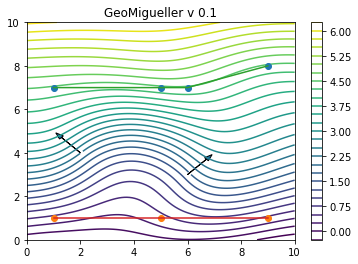

In [22]:
pot = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        pot[i,j] = estimator([i/10.,j/10.],[dip_pos_1, dip_pos_2], 
                             [layer_1, layer_2]
                             , sol, verbose = 0, C_01 = 1,
                             a = 6.)


plt.arrow(dip_pos_1[0],dip_pos_1[1], dip_pos_1_v[0]-dip_pos_1[0],
          dip_pos_1_v[1]-dip_pos_1[1], head_width = 0.2)
plt.arrow(dip_pos_2[0],dip_pos_2[1],dip_pos_2_v[0]-dip_pos_2[0], 
          dip_pos_2_v[1]-dip_pos_2[1], head_width = 0.2)

plt.plot(layer_1[:,0],layer_1[:,1], "o")
plt.plot(layer_2[:,0],layer_2[:,1], "o")
plt.plot(layer_1[:,0],layer_1[:,1], )
plt.plot(layer_2[:,0],layer_2[:,1], )
plt.contour(pot.transpose(),30,extent = (0,10,0,10) )
plt.colorbar()
plt.xlim(0,10)
plt.ylim(0,10)
plt.title("GeoMigueller v 0.1")
print (dip_pos_1_v, dip_pos_2_v, layer_1)

## La Buena

In [22]:
%matplotlib inline

In [23]:
def pla(angle1,angle2, C_0 = -14*1/6**2-0.2, C_01 = 1):
    layer_1 = np.array([[1,7],[5,6], [6,8], [9,9] ])
    layer_2 = np.array([[1,2],[5,3], [9,7]])
    layer_3 = np.array([[1,1],[3,2],[7,4]])

    dip_pos_1 = np.array([3,4])
    dip_angle_1 = angle1
    dip_pos_1_v = np.array([np.cos(np.deg2rad(dip_angle_1))*1,
                            np.sin(np.deg2rad(dip_angle_1))]) + dip_pos_1

    
    
    dip_pos_2 = np.array([6,6])
    dip_angle_2 = angle2
    dip_pos_2_v = np.array([np.cos(np.deg2rad(dip_angle_2))*1, 
                            np.sin(np.deg2rad(dip_angle_2))]) + dip_pos_2

    
    dip_pos_3 = np.array([9,5])
    dip_angle_3 = 90
    dip_pos_3_v = np.array([np.cos(np.deg2rad(dip_angle_3))*1, 
                            np.sin(np.deg2rad(dip_angle_3))]) + dip_pos_3
    #print b([dip_pos_1,dip_pos_2], [dip_pos_1_v,dip_pos_2_v],13)

    aa = A_matrix([layer_1,layer_2, layer_3], 
                  [dip_pos_1,dip_pos_2, dip_pos_3], a = 6.,
                  C_0= C_0,
                  C_01 = C_01)
    bb = b([dip_pos_1, dip_pos_2, dip_pos_3], 
           [dip_pos_1_v,dip_pos_2_v, dip_pos_3_v], len(aa))
#    bb[1] = 0
    print (bb)
    sol = np.linalg.solve(aa,bb)

    #sol[:-2] = 0
    #print aa 

    print( sol)
    pot = np.zeros((50,50))
    for i in range(50):
        for j in range(50):
            pot[i,j] = estimator([i/5.,j/5.],[dip_pos_1, dip_pos_2, dip_pos_3], 
                                 [layer_1, layer_2, layer_3]
                                 , sol, verbose = 0, C_01 = C_01,
                                 a = 6.)

    
    plt.arrow(dip_pos_1[0],dip_pos_1[1], dip_pos_1_v[0]-dip_pos_1[0],
              dip_pos_1_v[1]-dip_pos_1[1], head_width = 0.2)
    plt.arrow(dip_pos_2[0],dip_pos_2[1],dip_pos_2_v[0]-dip_pos_2[0], 
              dip_pos_2_v[1]-dip_pos_2[1], head_width = 0.2)
    plt.arrow(dip_pos_3[0],dip_pos_3[1],dip_pos_3_v[0]-dip_pos_3[0], 
              dip_pos_3_v[1]-dip_pos_3[1], head_width = 0.2)

    plt.plot(layer_1[:,0],layer_1[:,1], "o")
    plt.plot(layer_2[:,0],layer_2[:,1], "o")
    plt.plot(layer_3[:,0],layer_3[:,1], "o")
    plt.plot(layer_1[:,0],layer_1[:,1], )
    plt.plot(layer_2[:,0],layer_2[:,1], )
    plt.plot(layer_3[:,0],layer_3[:,1], )
    plt.contour(pot.transpose(),30,extent = (0,10,0,10) )
    plt.colorbar()
    plt.xlim(0,10)
    plt.ylim(0,10)
    plt.title("GeoMigueller v 0.1")
    print (dip_pos_1_v, dip_pos_2_v, layer_1)
    
    return pot

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in true

[-0.5  -0.64  0.    0.87  0.77  1.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
[-2.76  0.74  1.14  0.57  3.66  2.87  1.42 -1.7   1.02  1.83 -1.95 -0.81  0.9  -0.15  0.3 ]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


[ 2.5   4.87] [ 5.36  6.77] [[1 7]
 [5 6]
 [6 8]
 [9 9]]


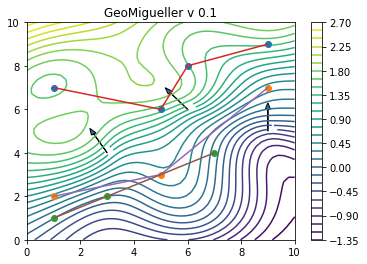

In [24]:
jhjs2 = pla(120,130,C_0=-0.5, C_01 = 1)

In [25]:
# jhjs = pla(120,-30, C_01 = 0.9)

In [26]:
jhjs = pla(120,-30)

R [[ 0.        3.605551  6.082763]
 [ 3.605551  0.        3.162278]
 [ 6.082763  3.162278  0.      ]]
hx [[ 0  3  6]
 [-3  0  3]
 [-6 -3  0]]
hx [[ 0  3  6]
 [-3  0  3]
 [-6 -3  0]]
hy [[ 0  2  1]
 [-2  0 -1]
 [-1  1  0]]
hy [[ 0  2  1]
 [-2  0 -1]
 [-1  1  0]]
hx [[ 0  3  6]
 [-3  0  3]
 [-6 -3  0]]
hy [[ 0  2  1]
 [-2  0 -1]
 [-1  1  0]]
[[-0.588889 -0.100938  0.        0.        0.048612 -0.      ]
 [-0.100938 -0.588889 -0.121682  0.048612  0.       -0.035414]
 [ 0.       -0.121682 -0.588889 -0.       -0.035414  0.      ]
 [ 0.        0.048612 -0.       -0.588889 -0.059509  0.      ]
 [ 0.048612  0.       -0.035414 -0.059509 -0.588889 -0.050069]
 [-0.       -0.035414  0.        0.       -0.050069 -0.588889]]
[-0.5       0.866025  0.        0.866025 -0.5       1.        0.        0.        0.        0.        0.        0.        0.        0.
  0.      ]
[-1.98635   2.626914 -0.543753  2.454589 -1.308389  1.95855   0.222263  0.304127  0.156125  0.970274 -0.65084   0.548595 -0.587844
 

/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in true_divide
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in multiply
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in true_divide
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:49: RuntimeWar

In [27]:
jh = pla(120,0)

R [[ 0.        3.605551  6.082763]
 [ 3.605551  0.        3.162278]
 [ 6.082763  3.162278  0.      ]]
hx [[ 0  3  6]
 [-3  0  3]
 [-6 -3  0]]
hx [[ 0  3  6]
 [-3  0  3]
 [-6 -3  0]]
hy [[ 0  2  1]
 [-2  0 -1]
 [-1  1  0]]
hy [[ 0  2  1]
 [-2  0 -1]
 [-1  1  0]]
hx [[ 0  3  6]
 [-3  0  3]
 [-6 -3  0]]
hy [[ 0  2  1]
 [-2  0 -1]
 [-1  1  0]]
[[-0.588889 -0.100938  0.        0.        0.048612 -0.      ]
 [-0.100938 -0.588889 -0.121682  0.048612  0.       -0.035414]
 [ 0.       -0.121682 -0.588889 -0.       -0.035414  0.      ]
 [ 0.        0.048612 -0.       -0.588889 -0.059509  0.      ]
 [ 0.048612  0.       -0.035414 -0.059509 -0.588889 -0.050069]
 [-0.       -0.035414  0.        0.       -0.050069 -0.588889]]
[-0.5       1.        0.        0.866025  0.        1.        0.        0.        0.        0.        0.        0.        0.        0.
  0.      ]
[-2.247577  3.126876 -0.640137  2.201872  0.069394  2.000452  0.637562 -0.297231  0.305559  1.237968 -0.836211  0.347865 -0.45094
 -

/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in true_divide
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in multiply
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in true_divide
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:49: RuntimeWar

In [28]:
jhjs = pla(-2,0)

R [[ 0.        3.605551  6.082763]
 [ 3.605551  0.        3.162278]
 [ 6.082763  3.162278  0.      ]]
hx [[ 0  3  6]
 [-3  0  3]
 [-6 -3  0]]
hx [[ 0  3  6]
 [-3  0  3]
 [-6 -3  0]]
hy [[ 0  2  1]
 [-2  0 -1]
 [-1  1  0]]
hy [[ 0  2  1]
 [-2  0 -1]
 [-1  1  0]]
hx [[ 0  3  6]
 [-3  0  3]
 [-6 -3  0]]
hy [[ 0  2  1]
 [-2  0 -1]
 [-1  1  0]]
[[-0.588889 -0.100938  0.        0.        0.048612 -0.      ]
 [-0.100938 -0.588889 -0.121682  0.048612  0.       -0.035414]
 [ 0.       -0.121682 -0.588889 -0.       -0.035414  0.      ]
 [ 0.        0.048612 -0.       -0.588889 -0.059509  0.      ]
 [ 0.048612  0.       -0.035414 -0.059509 -0.588889 -0.050069]
 [-0.       -0.035414  0.        0.       -0.050069 -0.588889]]
[ 0.999391  1.        0.       -0.034899  0.        1.        0.        0.        0.        0.        0.        0.        0.        0.
  0.      ]
[ 1.745852  1.529886 -0.092427  0.181988  0.1693    1.989711  0.049389 -0.152759  0.168621 -0.2107   -0.703772  0.105986  0.382493
 

/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in true_divide
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in multiply
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in true_divide
/home/bl3/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:49: RuntimeWar

In [29]:
137.769228/3.184139677, -106.724083/-2.9572844241540727772132

(43.267331830682124, 36.088541950282064)

In [30]:
3.16/0.15

21.06666666666667

In [31]:
59.12/3.15, 3.16/0.1425

(18.76825396825397, 22.17543859649123)

In [32]:
51.109568/3.15, 2.669329/0.1425

(16.225259682539683, 18.732133333333334)

In [33]:
45.047943/3.15, 2.29186/0.1425

(14.300934285714286, 16.083228070175437)

In [34]:
layer_1 = np.array([[1,7],[5,7],[6,7], [9,8], ])
layer_2 = np.array([[1,1],[5,1],[9,1], ])
layer_3 = np.array([[1,1],[3,2],[7,4]])

dip_pos_1 = np.array([2,4])
dip_angle_1 = 45
dip_pos_1_v = np.array([np.cos(np.deg2rad(dip_angle_1))*1,
                        np.sin(np.deg2rad(dip_angle_1))]) + dip_pos_1



dip_pos_2 = np.array([9,7])
dip_angle_2 = 90
dip_pos_2_v = np.array([np.cos(np.deg2rad(dip_angle_2))*1, 
                        np.sin(np.deg2rad(dip_angle_2))]) + dip_pos_2


dip_pos_3 = np.array([5,5])
dip_angle_3 = 90
dip_pos_3_v = np.array([np.cos(np.deg2rad(dip_angle_3))*1, 
                        np.sin(np.deg2rad(dip_angle_3))]) + dip_pos_3
#print b([dip_pos_1,dip_pos_2], [dip_pos_1_v,dip_pos_2_v],13)

aa = A_matrix([layer_1,layer_2], [dip_pos_1,dip_pos_2], a = 6., alpha = 14)
bb = b([dip_pos_1,dip_pos_2], [dip_pos_1_v,dip_pos_2_v], 11)
print bb
sol = np.linalg.solve(aa,bb)

#sol[:-2] = 0
#print aa 

print sol
pot = np.zeros((50,50))
for i in range(50):
    for j in range(50):
        pot[i,j] = estimator([i/5.,j/5.],[dip_pos_1,dip_pos_2], 
                             [layer_1,layer_2], sol, verbose = 0, alpha = 14,
                             a = 6.)

        
plt.arrow(dip_pos_1[0],dip_pos_1[1], dip_pos_1_v[0]-dip_pos_1[0],
          dip_pos_1_v[1]-dip_pos_1[1], head_width = 0.2)
plt.arrow(dip_pos_2[0],dip_pos_2[1],dip_pos_2_v[0]-dip_pos_2[0], 
          dip_pos_2_v[1]-dip_pos_2[1], head_width = 0.2)
#plt.arrow(dip_pos_3[0],dip_pos_3[1],dip_pos_3_v[0]-dip_pos_3[0], 
#          dip_pos_3_v[1]-dip_pos_3[1], head_width = 0.2)

plt.plot(layer_1[:,0],layer_1[:,1], "o")
plt.plot(layer_2[:,0],layer_2[:,1], "o")
#plt.plot(layer_3[:,0],layer_3[:,1], "o")
plt.plot(layer_1[:,0],layer_1[:,1], )
plt.plot(layer_2[:,0],layer_2[:,1], )
plt.contour(pot.transpose(),20,extent = (0,10,0,10) )
plt.colorbar()
plt.xlim(0,10)
plt.ylim(0,10)
print dip_pos_1_v, dip_pos_2_v, layer_1

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-34-f95248eef32c>, line 27)

In [ ]:
np.cos(np.deg2rad(45))

In [ ]:
layer_1 = np.array([[1,7],[5,7],[6,7], [9,7], ])
layer_2 = np.array([[1,1],[5,1],[9,1], ])
layer_3 = np.array([[1,1],[3,2],[7,4]])

dip_pos_1 = np.array([2,4])
dip_angle_1 = 100
dip_pos_1_v = np.array([np.cos(np.deg2rad(dip_angle_1))*1,
                        np.sin(np.deg2rad(dip_angle_1))]) + dip_pos_1



dip_pos_2 = np.array([8,5])
dip_angle_2 = 70
dip_pos_2_v = np.array([np.cos(np.deg2rad(dip_angle_2))*1, 
                        np.sin(np.deg2rad(dip_angle_2))]) + dip_pos_2


dip_pos_3 = np.array([8,5])
dip_angle_3 = 90
dip_pos_3_v = np.array([np.cos(np.deg2rad(dip_angle_3))*1, 
                        np.sin(np.deg2rad(dip_angle_3))]) + dip_pos_3
#print b([dip_pos_1,dip_pos_2], [dip_pos_1_v,dip_pos_2_v],13)

aa = A_matrix([layer_1,layer_2], [dip_pos_1,dip_pos_2], a = 6., alpha = 14)
bb = b([dip_pos_1,dip_pos_2], [dip_pos_1_v,dip_pos_2_v], 11)
print bb
sol = np.linalg.solve(aa,bb)

#sol[:-2] = 0
#print aa 

print sol
pot = np.zeros((50,50))
for i in range(50):
    for j in range(50):
        pot[i,j] = estimator([i/5.,j/5.],[dip_pos_1,dip_pos_2], 
                             [layer_1,layer_2], sol, verbose = 0, alpha = 14,
                             a = 6.)

        
plt.arrow(dip_pos_1[0],dip_pos_1[1], dip_pos_1_v[0]-dip_pos_1[0],
          dip_pos_1_v[1]-dip_pos_1[1], head_width = 0.2)
plt.arrow(dip_pos_2[0],dip_pos_2[1],dip_pos_2_v[0]-dip_pos_2[0], 
          dip_pos_2_v[1]-dip_pos_2[1], head_width = 0.2)
#plt.arrow(dip_pos_3[0],dip_pos_3[1],dip_pos_3_v[0]-dip_pos_3[0], 
#          dip_pos_3_v[1]-dip_pos_3[1], head_width = 0.2)

plt.plot(layer_1[:,0],layer_1[:,1], "o")
plt.plot(layer_2[:,0],layer_2[:,1], "o")
#plt.plot(layer_3[:,0],layer_3[:,1], "o")
plt.plot(layer_1[:,0],layer_1[:,1], )
plt.plot(layer_2[:,0],layer_2[:,1], )
plt.contour(pot.transpose(),20,extent = (0,10,0,10) )
plt.colorbar()
plt.xlim(0,10)
plt.ylim(0,10)
print dip_pos_1_v, dip_pos_2_v, layer_1

In [ ]:
%matplotlib inline

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.arange(0, 10, 0.1)
Y = np.arange(0, 10, 0.1)
X, Y = np.meshgrid(X, Y)
Z = pot.transpose()
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel("x")
ax.set_ylabel("y")

In [ ]:
print "layer1",(pot.transpose()[1,7],pot.transpose()[3,4],pot.transpose()[8,5],
                pot.transpose()[9,7])
print "layer2",pot.transpose()[1,3],pot.transpose()[3,4]
print "layer3",pot.transpose()[1,1],pot.transpose()[3,1],pot.transpose()[7,4]

In [ ]:
layer_1 = np.array([[5,5],[3,5]])
layer_2 = np.array([[1,3],[5,3],[7,3],[9,3]])


dip_pos_1 = np.array([2,4])
dip_angle_1 = 90
dip_pos_1_v = np.array([np.cos(np.deg2rad(dip_angle_1))*1,
                        np.sin(np.deg2rad(dip_angle_1))]) + dip_pos_1



dip_pos_2 = np.array([6,4])
dip_angle_2 = 90
dip_pos_2_v = np.array([np.cos(np.deg2rad(dip_angle_2))*1, 
                        np.sin(np.deg2rad(dip_angle_2))]) + dip_pos_2
#print b([dip_pos_1,dip_pos_2], [dip_pos_1_v,dip_pos_2_v],13)
bb = b([dip_pos_1], [dip_pos_1_v], 15 )
sol = np.linalg.solve(aa,bb)
print sol
pot = np.zeros((20,20))
for i in range(20):
    for j in range(20):
        pot[i,j] = estimator([i/2.,j/2.],[dip_pos_1,dip_pos_2], 
                             [layer_1,], sol, verbose = 0)

        
plt.arrow(dip_pos_1[0],dip_pos_1[1], dip_pos_1_v[0]-dip_pos_1[0],
          dip_pos_1_v[1]-dip_pos_1[1], head_width = 0.2)
plt.arrow(dip_pos_2[0],dip_pos_2[1],dip_pos_2_v[0]-dip_pos_2[0], 
          dip_pos_2_v[1]-dip_pos_2[1], head_width = 0.2)
plt.plot(layer_1[:,0],layer_1[:,1], "o")
plt.plot(layer_2[:,0],layer_2[:,1], "o")
plt.plot(layer_1[:,0],layer_1[:,1], )
plt.plot(layer_2[:,0],layer_2[:,1], )
plt.contour(pot,20, extent = (0,10,0,10) )
plt.colorbar()
plt.xlim(0,10)
plt.ylim(0,10)
print dip_pos_1_v, dip_pos_2_v, layer_1

In [ ]:
plt.arrow?

### Normal Universal cookriging

In [ ]:
def G_f(dips,x):
    dips = np.asarray(dips)
    
    a = np.asarray(dips)
    b = np.asarray(x)
   # print  a, a[:,0]
   # print  b,b[:,0]
    Gx =  b[0] - a[:,0]
    Gy =  b[1] -a[:,1] 
    G = np.hstack((Gx,Gy))
    
    return G

def b(x, dips,n):
    n -= len(dips)*2 # because x and y direction 
    G = G_f(dips,x)
    b = np.hstack((G, np.zeros(n)))
    return b,G

In [ ]:
b([1,1],[dip_pos_1,dip_pos_2],13)

In [ ]:
bb,g = b([1,1],[dip_pos_1,dip_pos_2],13)
len(bb)

In [ ]:
sol = np.linalg.solve(aa,bb)

In [ ]:
sol

In [ ]:
dip_pos_1, dip_pos_2

In [ ]:
z1 = dip_pos_1_v - dip_pos_1
z2 = dip_pos_2_v - dip_pos_2
print z1, z2

In [ ]:
g

In [ ]:
#=====================
# THE GRADIENTS

def h_f(dips, direct):

    if direct == "x":
        return np.abs(np.subtract.outer(dips[:,0],dips[:,0]))
    if direct == "y":
        return np.abs(np.subtract.outer(dips[:,1],dips[:,1]))

def C_G(dips, sig_z = 1., a = 6., nugget= 0.01):
    dips = np.asarray(dips)
    r = me.euclidean_distances(dips)
    for i in "xy":
        for j in "xy":
            if j == "x":
                h1 = h_f(dips, direct = i)
                h2 = h_f(dips, direct = j)
              #  print h1,h2
                C_G_row = (sig_z*h1*h2/a**2/r**2*
                          (1/r*cov_cubic_d1_f(r)-cov_cubic_d2_f(r)))
               # print 1/r*cov_cubic_d1_f(r), cov_cubic_d2_f(r)
            else:
                h1 = h_f(dips, direct = i)
                h2 = h_f(dips, direct = j)
                C_G_row = np.hstack((C_G_row, (sig_z*h1*h2/a**2/r**2*
                          (1/r*cov_cubic_d1_f(r)-cov_cubic_d2_f(r)))))
                
        if i == "x":
            C_G = C_G_row
        else:
            C_G = np.vstack((C_G, C_G_row))
    return np.nan_to_num(C_G)

## Estimator geomodeller (maybe)

In [ ]:
def estimator(x, dips, layers, sol, sig_z = 1., a = 6., alpha = 1, verbose = 0):
    x = np.asarray(x).reshape(1,-1)
    dips = np.asarray(dips)
    layers = np.asarray(layers)
    n = 0
    m = len(dips)
   # print layers
 #   print x.reshape(1,-1), dips
    r_i = me.euclidean_distances(dips,x)
    hx = h_f_GI(dips, x, "x")
    Cov_d1 = cov_cubic_d1_f(r_i)
    KzGx =  sol[:m] * np.squeeze(alpha * sig_z / a**2 * hx / r_i * Cov_d1)
    hy = h_f_GI(dips, x, "y")
    KzGy =  sol[m:2*m] * np.squeeze(alpha * sig_z / a**2 * hy / r_i * Cov_d1)
    
    for s in range(len(layers)):
        n += len(layers[s][1:])
        a = cov_cubic_layer(x, layers[s][1:])
        b = cov_cubic_layer(x, layers[s][0].reshape(1,-1))
        # print a,b
        if s == 0:
            L = np.array(sol[2*m:2*m+n]*(a-b))
        else:
            L = np.hstack((L,sol[2*m+n2:2*m+n]*(a-b)))
        n2 = n  
    L = np.squeeze(L)
   # print m,n
    univ = (sol[2*m+n]*x[0,0]**2 + sol[2*m+n+1] * x[0,1]**2 
            + sol[2*m+n+2]* x[0,0]*x[0,1] 
           + sol[2*m+n+3] * x[0,0]
           + sol[2*m+n+4] * x[0,1])
    
    if verbose != 0:
        print KzGx, KzGy, L, univ
    z_star = np.sum(KzGx)+np.sum(KzGy)+np.sum(L)+univ
    return z_star

In [ ]:
#========================================
#THE INTERACTION GRADIENTS/INTERFACES

def h_f_GI(dips, layers, direct):
    if direct == "x":
        return (np.subtract.outer(dips[:,0],layers[:,0]))
    if direct == "y":
        return (np.subtract.outer(dips[:,1],layers[:,1]))
    
def C_GI(dips,layers,  sig_z = 1., a = 6., alpha = 14, verbose = 0):
    dips = np.asarray(dips)
    layers = np.asarray(layers)
    for k in range(len(layers)):
        for i in "xy":
            r = me.euclidean_distances(dips,layers[k])
            h1 = h_f_GI(dips,layers[k], i)
           
            Cov_d1 = cov_cubic_d1_f(r)
            if verbose != 0:
                print "dips", dips
                print "layers", layers
                print "h1", h1, h1[:,0]
                print ""
                print "r", r, r[:,0]
                print ""
                print "Cov_d1", Cov_d1
            if i == "x":
                cov_1 = alpha * sig_z / a**2 * h1[:,0] / r[:,0] * Cov_d1[:,0]
                cov_j = alpha * sig_z / a**2 * h1[:,1:] / r[:,1:] * Cov_d1[:,1:]
               # C_GI_row = alpha * sig_z / a**2 * h1 / r * Cov_d1
                #print "cov_j, cov_1", cov_j, cov_1.reshape(-1,1)
             #   pdb.set_trace()
                C_GI_row = cov_j.transpose()-cov_1#.transpose()
            else:
                cov_1 = alpha * sig_z / a**2 * h1[:,0] / r[:,0] * Cov_d1[:,0]
                cov_j = alpha * sig_z / a**2 * h1[:,1:] / r[:,1:] * Cov_d1[:,1:]
                #C_GI_row = np.hstack((C_GI_row,
               # alpha * sig_z / a**2 * h1 / r * Cov_d1))
                #pdb.set_trace()
                C_GI_row = np.hstack((C_GI_row, cov_j.transpose()-cov_1))
                #.reshape(-1,1)))
        if k==0:
            C_GI = C_GI_row
        else:
            #pdb.set_trace()
            C_GI = np.vstack((C_GI,C_GI_row))
            
    return C_GI